In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:

import os
import cv2
import random
import pathlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Tuple, Dict, List

import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader

import albumentations
from albumentations.pytorch.transforms import ToTensor, ToTensorV2

from PIL import Image, ImageFile, ImageFont, ImageDraw, ImageEnhance
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings('ignore')

FUSED_SHAPE = (640, 480)
ORIGINAL_SHAPE = (4000, 3000)

In [103]:
from datasets import load_dataset

dataset = load_dataset("mllab/alfafood")


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

# EDA

In [ ]:
len(dataset['train']) # all data in train

3346

In [ ]:
original_shape = dataset['train'][0]['image'].size
original_shape

(4000, 3000)

In [ ]:
dataset['train'][4]

{'image': <PIL.Image.Image image mode=RGB size=4000x3000>,
 'objects': {'bbox': [[1398.17, 354.76, 486.59, 365.85],
   [406.71, 18.17, 2513.41, 1532.93],
   [1328.66, 680.37, 610.97, 197.56]],
  'categories': [9, 99, 11]}}

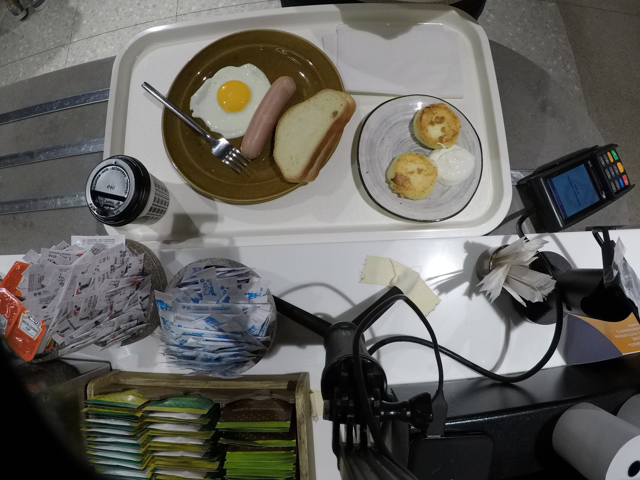

In [ ]:
dataset['train'][5]['image'].resize(FUSED_SHAPE)

# NB! Delete after ended

In [ ]:
def fused_bbox(bboxes, original_shape, fused_shape):

    x_fused = fused_shape[0] / original_shape[0]
    y_fused = fused_shape[1] / original_shape[1]

    for i in range(len(bboxes)):
        bboxes[i][0] = bboxes[i][0] * x_fused
        bboxes[i][1] = bboxes[i][1] * y_fused
        bboxes[i][2] = bboxes[i][2] * x_fused
        bboxes[i][3] = bboxes[i][3] * y_fused

    return bboxes

In [ ]:
bbox_transform = albumentations.Compose(
    [albumentations.Resize(height=FUSED_SHAPE[1], width=FUSED_SHAPE[0]),
     albumentations.HorizontalFlip(p=0.6),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels'])
)

In [104]:
dataset['train'][5]['objects']['bbox']

[[2408.8, 636.46, 561.7, 610.14],
 [527.44, 969.39, 530.49, 446.34],
 [1185.98, 384.02, 515.85, 486.59],
 [1500.61, 471.83, 354.88, 519.51],
 [1701.83, 548.66, 486.59, 610.97],
 [1862.8, 559.63, 369.52, 589.03],
 [644.51, 18.17, 2539.03, 1500.0]]

In [105]:
images = [dataset['train'][i]['image'].resize(FUSED_SHAPE) for i in range(10)]
objects = [dataset['train'][i]['objects'] for i in range(10)]

for i in range(10):
    if objects[i]['bbox'] != []:
        objects[i]['bbox'] = fused_bbox(objects[i]['bbox'], ORIGINAL_SHAPE, FUSED_SHAPE)


class AlfaFoodDataset(Dataset):

    def __init__(self, images, objects, transform=None):
        self.images = images
        self.objects = objects
        self.transform = transform
        target = dict()
        self.list_transforms = np.zeros(shape=(len(self.images),))


    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Tuple[Tuple[int]], Tuple[int]]:
        "Returns one sample of data: image, labels, bboxes"

        image = np.array(self.images[index].convert('RGB'))#.transpose(1, 2, 0)
        bboxes = self.objects[index]['bbox']
        labels = self.objects[index]['categories']

        if self.transform and self.list_transforms[index] == 0:
            for bbox in bboxes:
                bbox[2] += bbox[0]
                bbox[3] += bbox[1]

            # print(bboxes)
            transformed = self.transform(image = image, bboxes = bboxes, labels = labels)
            image = np.array(transformed['image']).transpose(1, 2, 0)
            bboxes = transformed['bboxes']
            labels = transformed['labels']

            self.list_transforms[index] = 1

        target['boxes'] = bboxes
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)

        return image, target


    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.images)

data = AlfaFoodDataset(images, objects, transform = bbox_transform)

img, target = data[7]

# print(labels)


In [106]:
img, target = data[8]

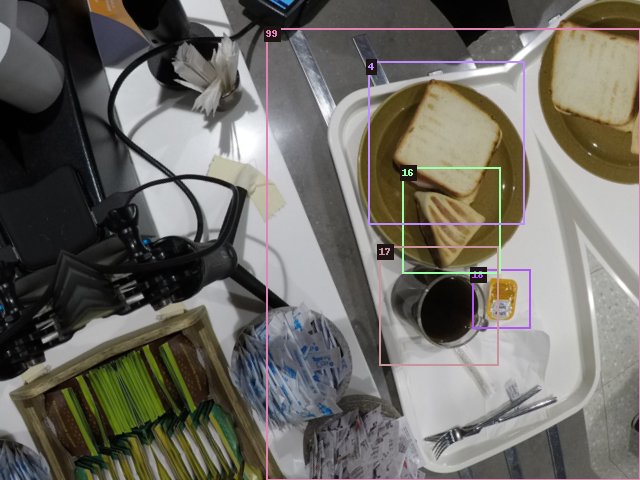

In [107]:
# img, bboxes, labels = data[4]
def show_image_with_objects(image, bboxes, labels=None):

    img = Image.fromarray(image)

    color = list((random.randint(40, 240), random.randint(40, 255), random.randint(60, 255)) for i in range(100))

    random.shuffle(color)

    for i in range(len(bboxes)):
        draw = ImageDraw.Draw(img)
        draw.rectangle(bboxes[i], outline = color[i], width=2)

        bbox = draw.textbbox((bboxes[i][0], bboxes[i][1]), f"{labels[i]}")
        draw.rectangle((bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2), fill=(30, 20, 20))
        draw.text((bboxes[i][0], bboxes[i][1]), f"{labels[i]}", color[i])
    return img

show_image_with_objects(img, target['boxes'], target['labels'])


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 125  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# model(img)
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 139MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.3.0+cu121
Torchvision Version:  0.18.0+cu121


In [122]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = AlfaFoodDataset(images[1:5], objects[1:5], transform = bbox_transform)
test_dataset = AlfaFoodDataset(images, objects, transform = None)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
# test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2)


In [123]:
image, _ = next(iter(data_loader))
torch.from_numpy(image[0]).float().permute(2, 0, 1).shape
_

({'boxes': [(438.2650962963208,
    132.14524897438923,
    501.67720805892725,
    213.59605068874708),
   (295.4793440337437, 0.0, 566.0526973517586, 387.4404178291255),
   (412.43199395860745,
    124.39027161853964,
    450.25048073599976,
    223.9726710425574)],
  'labels': tensor([ 9, 99, 11])},
 {'boxes': [(438.2650962963208,
    132.14524897438923,
    501.67720805892725,
    213.59605068874708),
   (295.4793440337437, 0.0, 566.0526973517586, 387.4404178291255),
   (412.43199395860745,
    124.39027161853964,
    450.25048073599976,
    223.9726710425574)],
  'labels': tensor([ 9, 99, 11])},
 {'boxes': [(438.2650962963208,
    132.14524897438923,
    501.67720805892725,
    213.59605068874708),
   (295.4793440337437, 0.0, 566.0526973517586, 387.4404178291255),
   (412.43199395860745,
    124.39027161853964,
    450.25048073599976,
    223.9726710425574)],
  'labels': tensor([ 9, 99, 11])},
 {'boxes': [(438.2650962963208,
    132.14524897438923,
    501.67720805892725,
    213.

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(126)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [113]:
for imgs, annotations in data_loader:
  print([{k: v for k, v in t.items()} for t in annotations])

[{'boxes': [[80.8784, 3.4928, 409.7552, 246.4384], [215.512, 18.712, 97.17120000000001, 110.0496], [251.8048, 0.0, 111.3952, 142.8096], [442.6336, 170.3216, 42.7328, 46.8288], [218.4384, 111.2, 86.0496, 43.3168], [210.8288, 83.68799999999999, 72.5856, 50.3408], [95.51200000000001, 129.3472, 72.5856, 80.7792], [323.2192, 119.3952, 79.024, 86.04799999999999]], 'labels': tensor([99,  6,  3,  7,  9,  9, 10,  8])}, {'boxes': [[80.8784, 3.4928, 409.7552, 246.4384], [215.512, 18.712, 97.17120000000001, 110.0496], [251.8048, 0.0, 111.3952, 142.8096], [442.6336, 170.3216, 42.7328, 46.8288], [218.4384, 111.2, 86.0496, 43.3168], [210.8288, 83.68799999999999, 72.5856, 50.3408], [95.51200000000001, 129.3472, 72.5856, 80.7792], [323.2192, 119.3952, 79.024, 86.04799999999999]], 'labels': tensor([99,  6,  3,  7,  9,  9, 10,  8])}, {'boxes': [[80.8784, 3.4928, 409.7552, 246.4384], [215.512, 18.712, 97.17120000000001, 110.0496], [251.8048, 0.0, 111.3952, 142.8096], [442.6336, 170.3216, 42.7328, 46.8288]

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(torch.from_numpy(img).float().permute(2, 0, 1).to(device) for img in imgs)
        annotations = [{k: torch.Tensor(v).to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 124.85045623779297, time : 96.56332731246948
